In [1]:
# How to visualize transportation in the City of Madison in order to reduce redundancy of routes 
# and stops with the proposed BRT system being implimented... 

import geopandas 
import pandas as pd
pd.set_option('max_colwidth', 200)
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from shapely.geometry import Point, Polygon, LineString
import seaborn as sns 
sns.set()
import descartes
%matplotlib inline
from math import sin, cos, sqrt, atan2, radians
import numpy as np


# downloaded from here: http://data-cityofmadison.opendata.arcgis.com/datasets/city-limit
# downloaded from here: http://data-cityofmadison.opendata.arcgis.com/datasets/c46082b091a941f8b2ded1dd115a1a05_8

lakes = geopandas.read_file("Lakes_and_Rivers")
madison = geopandas.read_file("City_Limit")

First we import the relevant libraries that will be necessary to visualize our data. The most important are the geopandas, pandas, numpy, matplotlib, and geopy modules. In addition, we get the shape files of the city of Madison and the surrounding lakes which will serve as a template that we can plot on top of to better visualize our transportation data.

Next, we get the primary data that we will work with. The data presented below are the characteristics of the current weekday bus routes for the city of Madison. To do this we read the data with the geopandas module to turn our data into a dataframe. 

In [2]:
#https://data-cityofmadison.opendata.arcgis.com/datasets/metro-transit-ridership-by-route-weekday?geometry=-89.671%2C42.985%2C-89.23%2C43.161

weekday_bus = geopandas.read_file("Metro_Transit_Ridership_by_Route_Weekday")
weekday_bus.head()


,OBJECTID,StopID,Route,Lat,Lon,DailyBoard,DotSize,geometry
0,16341,4100,4,43.038895,-89.394824,189.84,1898447.45,POINT (-89.39481797199609 43.03888706322148)
1,16342,4100,5,43.038895,-89.394824,210.71,2107109.73,POINT (-89.39481797199609 43.03888706322148)
2,16343,4100,13,43.038895,-89.394824,79.50,795000.00,POINT (-89.39481797199609 43.03888706322148)
3,16344,4100,16,43.038895,-89.394824,185.31,1853106.79,POINT (-89.39481797199609 43.03888706322148)
4,16345,4100,18,43.038895,-89.394824,299.38,2993805.57,POINT (-89.39481797199609 43.03888706322148)


We have route numbers, coordinates, Daily boarding numbers, and the geometries of the shapefile data. 

Next, we get the BRT data and metro data in seperate dataframes. We then get the coordinates of each stop.

In [3]:
#metro data
metro_data = geopandas.read_file("MetroBusRoutes.gdb")
list_metro = []
for index, row in metro_data.iterrows():
    list_metro.append(Point(float(row["stop_lon"]),float(row["stop_lat"]))) 

metro_series = pd.Series(list_metro)
metro_coord = pd.DataFrame({"Coordinates": metro_series})
metro_coord = geopandas.GeoDataFrame(metro_coord, geometry='Coordinates') # coordinates of metro routes

#BRT data 
#https://data-cityofmadison.opendata.arcgis.com/datasets/bus-rapid-transit-stops
# using new data for brt from the madison data instead of the BRT.gdb
brt_data = geopandas.read_file("Bus_Rapid_Transit_Stops")
list_brt = []
for index, row in brt_data.iterrows():
    list_brt.append(Point(float(row["stop_lon"]),float(row["stop_lat"])))

brt_series = pd.Series(list_brt)
brt_coord = pd.DataFrame({"Coordinates": brt_series})
brt_coord = geopandas.GeoDataFrame(brt_coord, geometry='Coordinates') # coordinates for BRT routes

weekday_bus['coord'] = ''
weekday_bus['coord'] = list(zip(weekday_bus.Lat, weekday_bus.Lon)) # actually creating the coordinates for Metro
brt_data['coord'] = list(zip(brt_data.stop_lat, brt_data.stop_lon)) # actually creating the coordinates for BRT 



Now that we have the coordinates of both the existing stops and the BRT stops, we can compute the distance betwwen the existing stops and the BRT stops. We do this by indexing the BRT stops, then we find the distance of each existing stop to the nearest indexed BRT stop. We can use the geodesic function from geopy to find the distance in kilometers. 

More on the geodesic function here: https://en.wikipedia.org/wiki/Geodesic, https://geopy.readthedocs.io/en/stable/

In [4]:
from haversine import haversine, Unit
import geopy
from geopy import distance

weekday_bus['brt_index'] = ''  # creating row for index
weekday_bus['distance_to_brt'] = '' # creating row for distance

for index, row in weekday_bus.iterrows():
    list_bus = []
    for index1, row1 in brt_data.iterrows(): 
        dist = geopy.distance.geodesic(row['coord'], row1['coord']).km # calculating the distance
        list_bus.append(dist) # appending distances to a list
    list_bus_df = pd.DataFrame(list_bus)
    list_bus_df.columns =['distance_from_nearest_brt'] # appending distances to a dataframe

    index_of_brt = list_bus_df['distance_from_nearest_brt'].idxmin()
    distance_to_nearest_brt = list_bus_df['distance_from_nearest_brt'].min() # distances to nearest BRT stop

    weekday_bus.at[index, 'brt_index'] = index_of_brt
    weekday_bus.at[index, 'distance_to_brt'] = distance_to_nearest_brt
weekday_bus[:1] # final dataframe with distances and BRT indexes

,OBJECTID,StopID,Route,Lat,Lon,DailyBoard,DotSize,geometry,coord,brt_index,distance_to_brt
0,16341,4100,4,43.038895,-89.394824,189.84,1898447.45,POINT (-89.39481797199609 43.03888706322148),"(43.038895, -89.394824)",59,0.011364


In [5]:
# Here we get the actual lines of the metro and BRT routes

#BRT data lines
#http://data-cityofmadison.opendata.arcgis.com/datasets/bus-rapid-transit-system-lines
brt_data_line = geopandas.read_file("Bus_Rapid_Transit_System_Lines")
brt_coord_line = geopandas.GeoDataFrame(brt_data_line, geometry='geometry')


#metro bus route data 2019
#http://data-cityofmadison.opendata.arcgis.com/datasets/metro-transit-bus-routes
transit_data = geopandas.read_file("Metro_Transit_Bus_Route_Trips")
transit_data_weekday = transit_data.loc[transit_data['service_na'].isin(['Standard Weekday','Weekday'])]
transit_data_weekday[:1]


#https://data-cityofmadison.opendata.arcgis.com/datasets/metro-transit-ridership-by-route-weekday?geometry=-89.671%2C42.985%2C-89.23%2C43.161
#weekday_bus_with_brt_distance = geopandas.read_file("weekday_bus_with_brt_distance.gpkg", driver = "GPKG")
#weekday_bus_with_brt_distance.distance_to_brt = weekday_bus_with_brt_distance.distance_to_brt.astype(float)
unique_value = weekday_bus['Route'].unique()
unique_value.sort()
unique_value


array([ 1,  2,  3,  4,  5,  6, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 44, 47, 48, 49, 50, 51, 52, 55, 56, 57, 58, 67, 70, 71, 72, 73,
       75, 80, 81, 82, 84])

In [6]:
# mapping of the metro stop to the nearest BRT stop
def mapping(route_number_table):
    for bus_number in route_number_table['Route'].unique():
        row_bus = weekday_bus[weekday_bus['Route'] == bus_number]  
        weekday_bus_series = pd.Series(row_bus["geometry"])
        weekday_bus_coord = pd.DataFrame({"Coordinates": weekday_bus_series})
        weekday_bus_coord = geopandas.GeoDataFrame(weekday_bus_coord, geometry='Coordinates')
        weekday_bus_coord.plot(color='blue', ax=ax, markersize= 35)

    route_row = transit_data_weekday[transit_data_weekday['trips_ro_1'] == bus_number]
    list_weekday_bus = []
    for index, row in route_row.iterrows():
        list_weekday_bus.append(row["geometry"])
        weekday_bus_series = pd.Series(list_weekday_bus)
        weekday_bus_coord = pd.DataFrame({"Coordinates": weekday_bus_series})
        weekday_bus_coord = geopandas.GeoDataFrame(weekday_bus_coord, geometry='Coordinates')
        weekday_bus_coord.plot(color='blue', ax=ax)

    for index, row in row_bus.iterrows():
        metro_point = row['geometry']
        brt_point = brt_data.iloc[int(row['brt_index'])]['geometry']
        line_A = LineString([[metro_point.x, metro_point.y], [brt_point.x, brt_point.y]])
        weekday_bus_series = pd.Series(line_A)
        weekday_bus_coord = pd.DataFrame({"Coordinates": weekday_bus_series})
        weekday_bus_coord = geopandas.GeoDataFrame(weekday_bus_coord, geometry='Coordinates')
        weekday_bus_coord.plot(color='red', ax=ax)
        



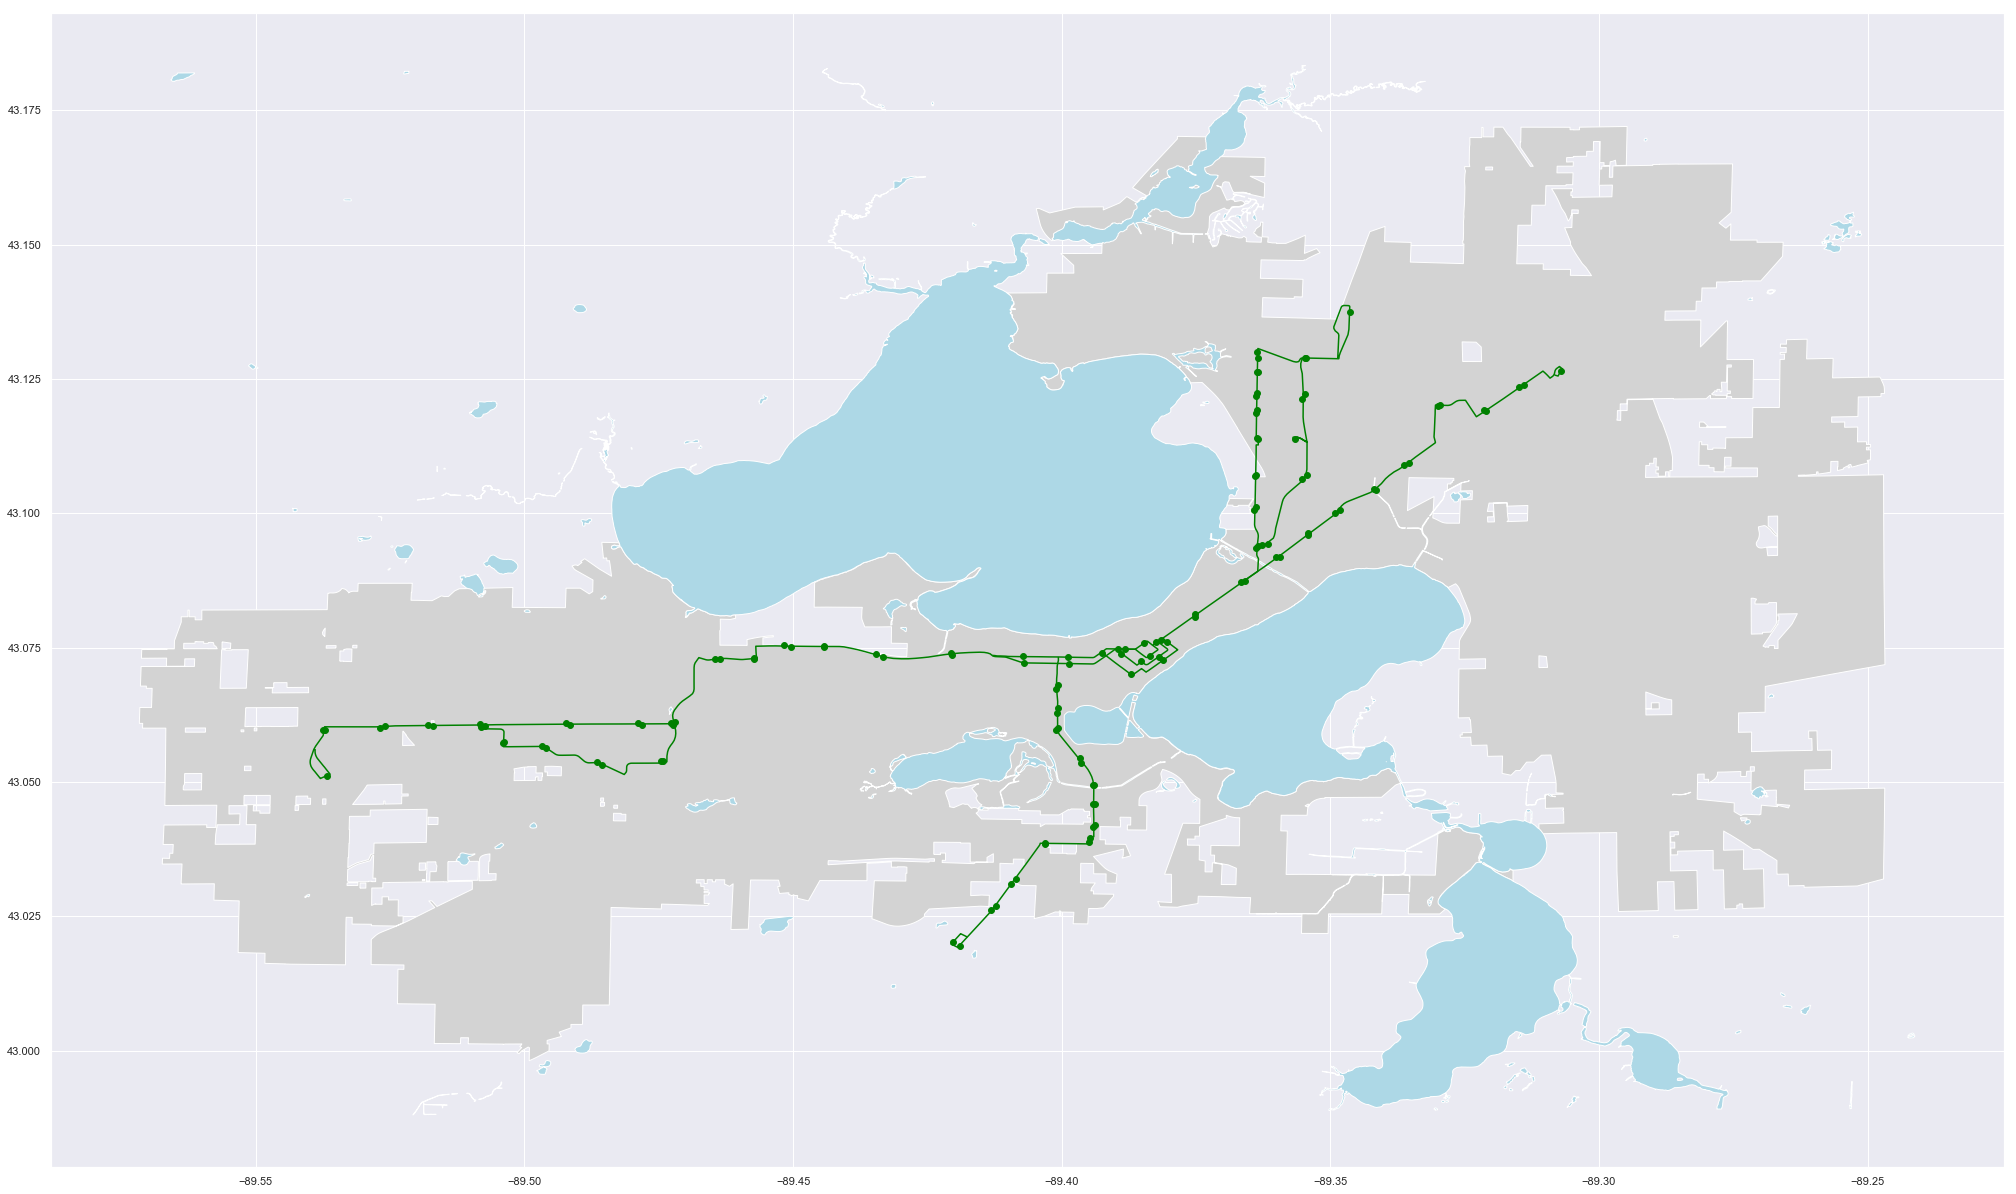

In [9]:
# A look at the proposed BRT system.

ax = madison.plot(color="lightgray", figsize=(35,35))
lakes.plot(color="lightblue", ax=ax)
brt_coord.plot(color="green", ax=ax, markersize= 35)
brt_coord_line.plot(color="green", ax=ax)

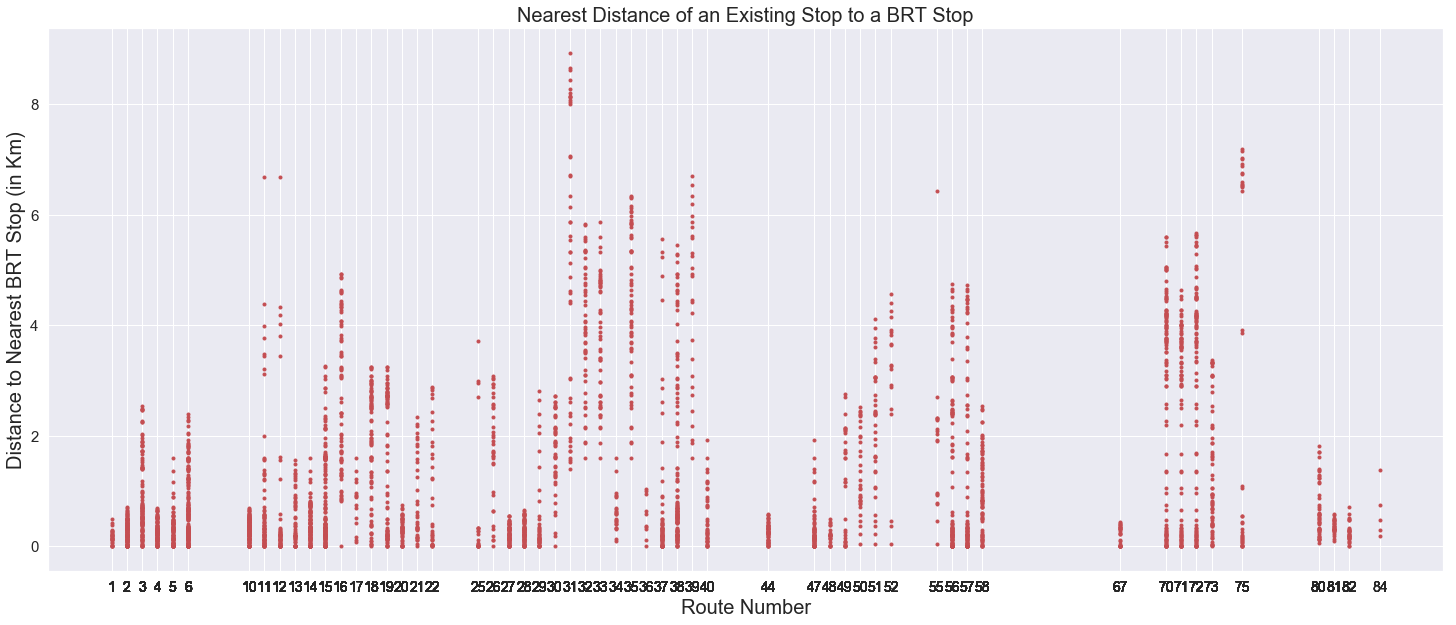

In [7]:
# creating visualization based off of distance of each stop to nearest BRT stop grouped by route

y = weekday_bus["distance_to_brt"]
x = weekday_bus["Route"]

plt.figure(figsize=(25,10))
plt.scatter(x, y, marker=".", c='r')

plt.title('Nearest Distance of an Existing Stop to a BRT Stop', size=20)
plt.xlabel('Route Number', size=20)
plt.ylabel('Distance to Nearest BRT Stop (in Km)', size=20)
plt.xticks(weekday_bus['Route'], size=14)
plt.yticks(size=15)
plt.show()

We can clearly see some routes have a lot of stops which are close to the proposed BRT routes. Some of the routes include the 1, 2, 4, 5, 10, 27, 28, 44, 67, 81, and the 82. Since the 2, 10, 81, and 82 either serve various functions for the campus, have a high ridership, or are critical for access to the UW hospital, we chose to analyze the 1, 4, 5, 27, 28, 44, and 67 bus routes. We use our previous functions that we defined to map the distances of the existing stops to the nearest BRT stop.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


count    29.000000
mean      0.179172
std       0.125514
min       0.005439
25%       0.108280
50%       0.173806
75%       0.251085
max       0.492230
Name: distance_to_brt, dtype: float64

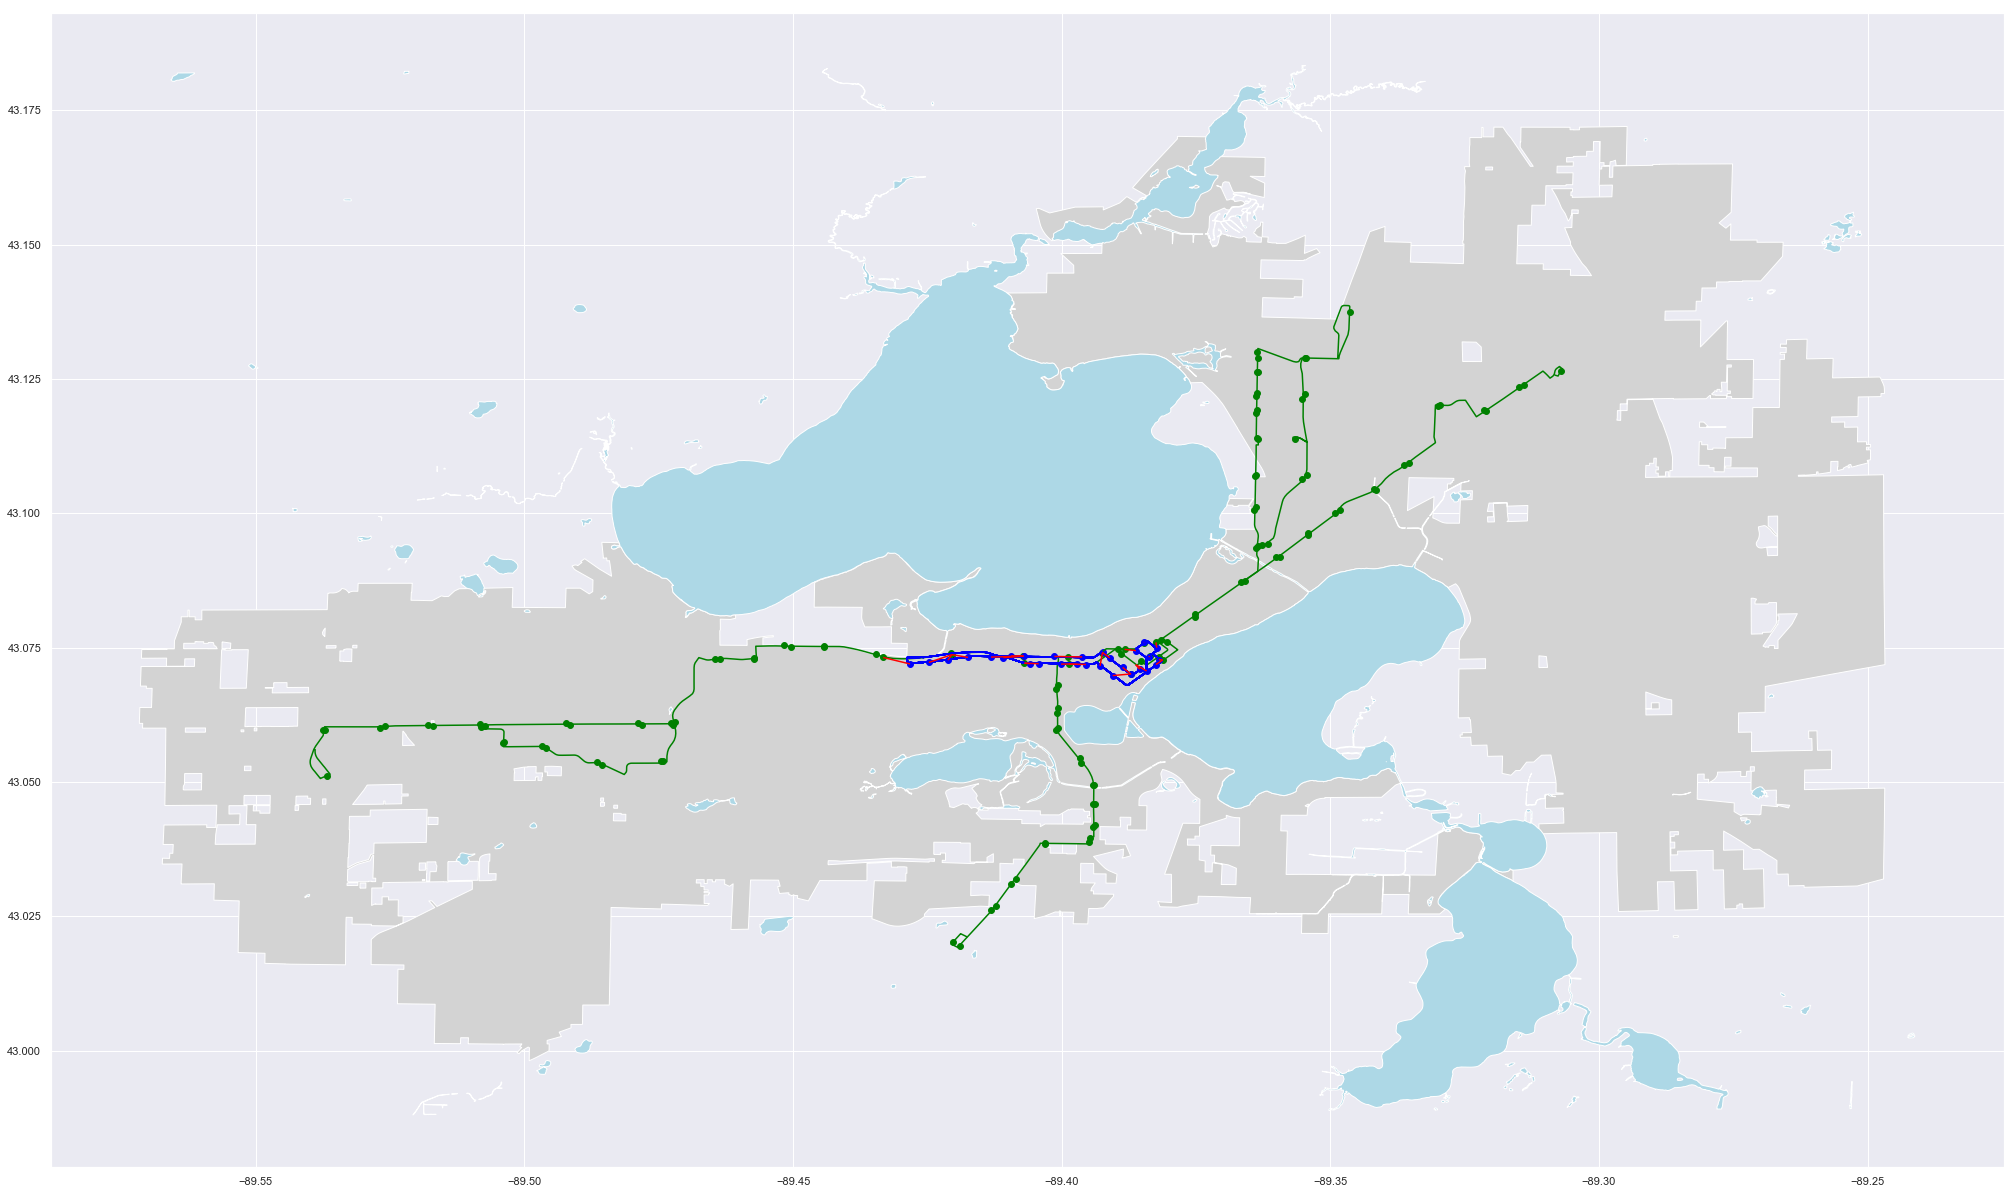

In [10]:
#bus 1 
ax = madison.plot(color="lightgray", figsize=(35,35))
lakes.plot(color="lightblue", ax=ax)
brt_coord.plot(color="green", ax=ax, markersize= 35)
brt_coord_line.plot(color="green", ax=ax)

route_number_table = weekday_bus[weekday_bus['Route'] == 1]
mapping(route_number_table)
route_number_table.distance_to_brt = route_number_table.distance_to_brt.astype(float)
route_number_table['distance_to_brt'].describe()

count    111.000000
mean       0.274405
std        0.179404
min        0.005685
25%        0.130146
50%        0.246896
75%        0.373465
max        0.693609
Name: distance_to_brt, dtype: float64

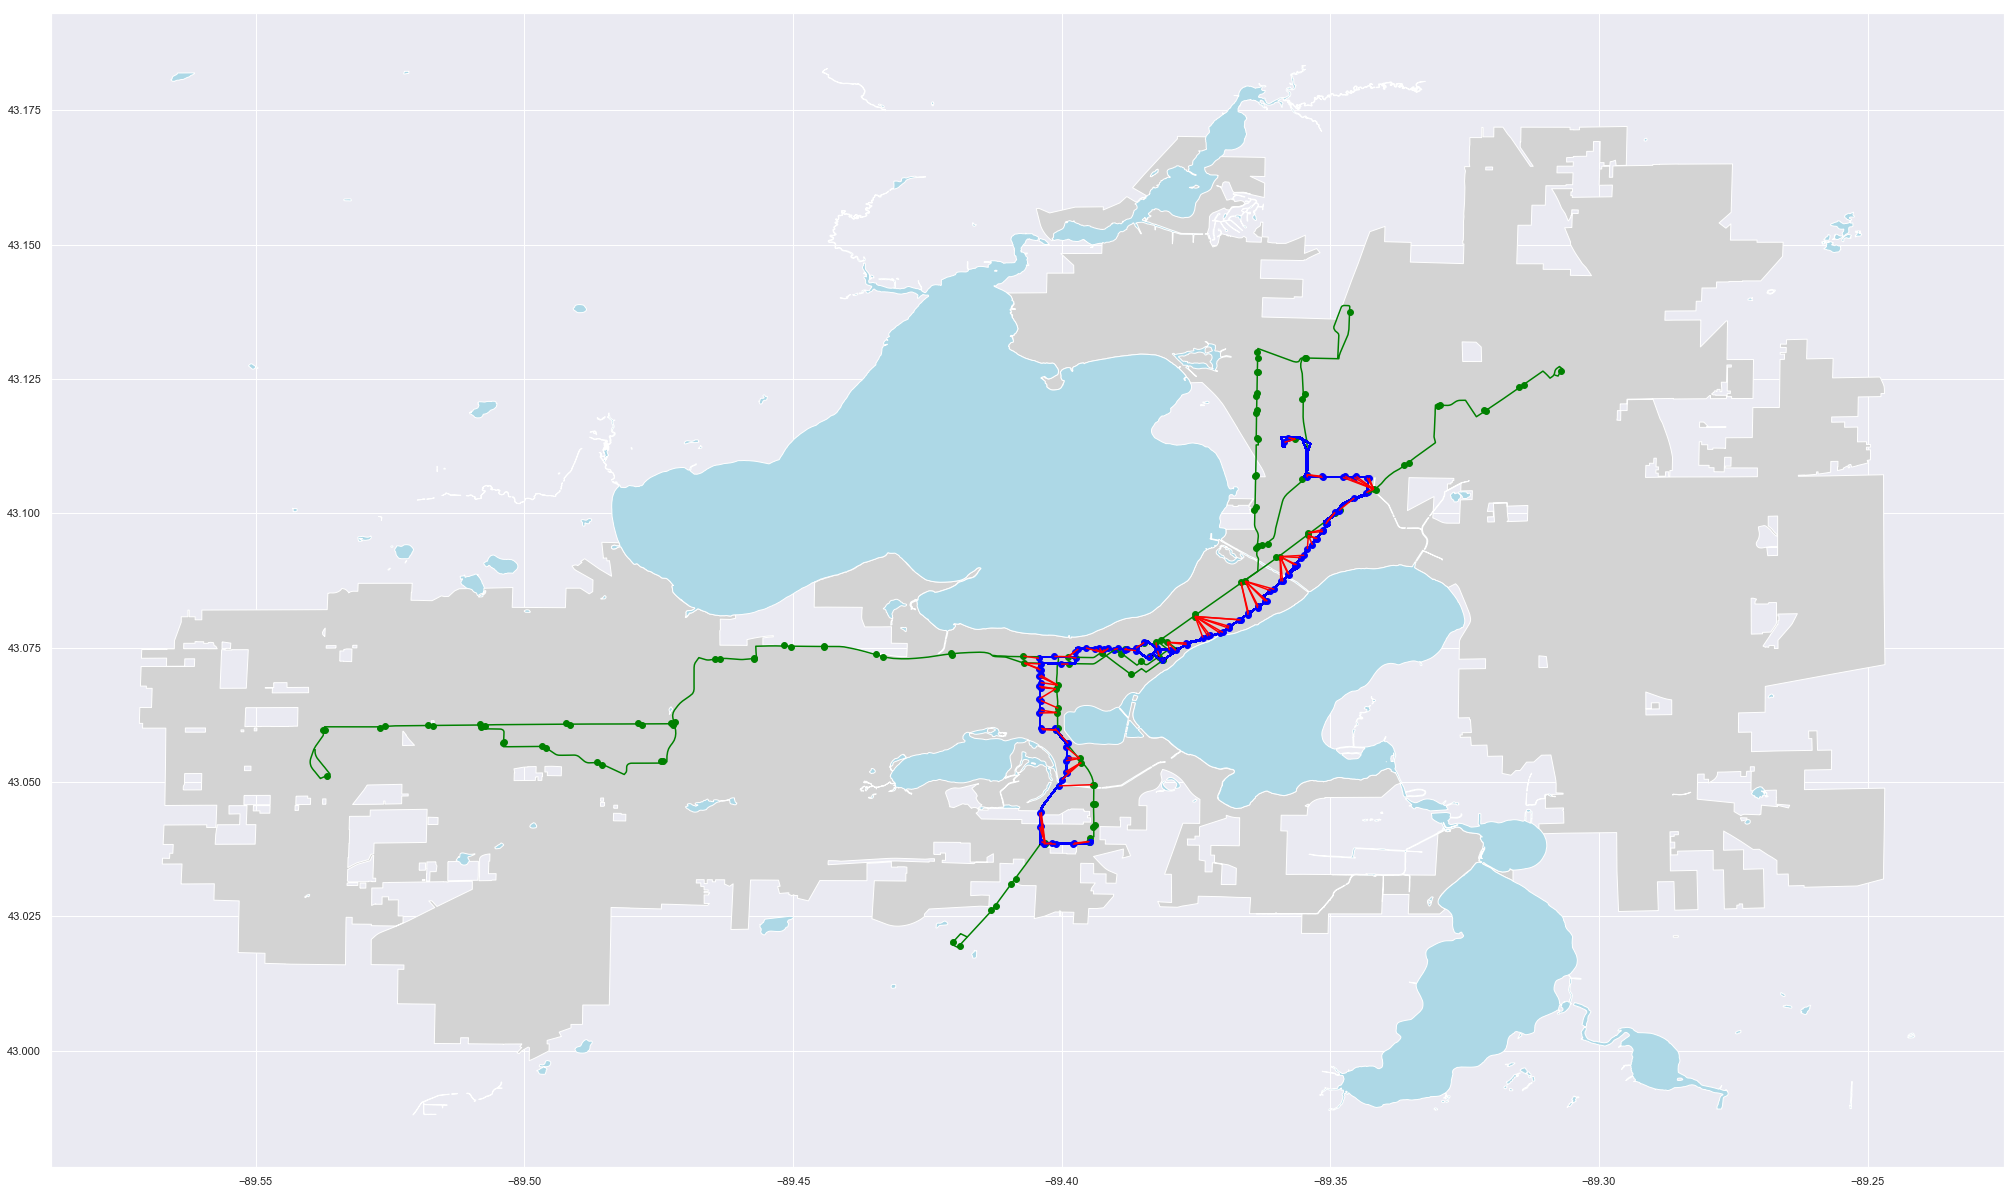

In [12]:
#bus 4
ax = madison.plot(color="lightgray", figsize=(35,35))
lakes.plot(color="lightblue", ax=ax)
brt_coord.plot(color="green", ax=ax, markersize= 35)
brt_coord_line.plot(color="green", ax=ax)

route_number_table = weekday_bus[weekday_bus['Route'] == 4]
mapping(route_number_table)
route_number_table.distance_to_brt = route_number_table.distance_to_brt.astype(float)
route_number_table['distance_to_brt'].describe()